In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import xgboost
import numpy as np
from scipy.sparse import csr_matrix, diags
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [92]:
# Adjacency generating functions
def make_adjacency(leaves):

    n_samples, n_trees = leaves.shape
    
    # give each (tree, leaf) a unique global ID
    unique_leafIDs = []
    offset = 0
    offsets = []
    mappings = []
    for t in range(n_trees):
        col = leaves[:, t]
        # relabel leaves 
        unique, relabeled = np.unique(col, return_inverse=True)
        unique_leafIDs.append(relabeled + offset)
        mapping = {u: i for i, u in enumerate(unique)}
        mappings.append(mapping)
        offsets.append(offset)
        offset += len(unique)
    leafIDs_global = np.column_stack(unique_leafIDs)

    # Build sparse membership matrix M
    row_ind = np.repeat(np.arange(n_samples), n_trees)
    col_ind = leafIDs_global.ravel()
    data = np.ones_like(row_ind, dtype=np.float32)

    M = csr_matrix((data, (row_ind, col_ind)), shape=(n_samples, offset))

    # leaf sizes and weights
    leaf_sizes = np.array(M.sum(axis=0)).ravel()
    leaf_weights = 1.0 / np.maximum(leaf_sizes, 1)  # avoid div by zero

    M_norm = M @ diags(leaf_weights)
    A = (M_norm @ M.T) / n_trees
    
    metadata = {
        "offsets": offsets,
        "leaf_weights": leaf_weights,
        "M_norm": M_norm,
        "total_leaves": offset,
        "mappings": mappings
    }
    return A.toarray(), metadata

def new_adjacency(new_leaves, metadata):
    offsets = metadata["offsets"]
    leaf_weights = metadata["leaf_weights"]
    M_norm_train = metadata["M_norm"]
    n_new, n_trees = new_leaves.shape
    total_leaves = metadata["total_leaves"] 
    mappings = metadata["mappings"]

    new_leafIDs = []
    for t in range(n_trees):
        mapping = mappings[t]
        relabeled = np.array([mapping[lid] for lid in new_leaves[:, t]])
        new_leafIDs.append(relabeled + offsets[t])
    leafIDs_global = np.column_stack(new_leafIDs)
    row_ind = np.repeat(np.arange(n_new), n_trees)
    col_ind = leafIDs_global.ravel()

    data = np.ones_like(row_ind, dtype=np.float32)

    M_new = csr_matrix((data, (row_ind, col_ind)), shape=(n_new, total_leaves))
    M_norm_new = M_new @ diags(leaf_weights)
    A_new = (M_norm_new @ M_norm_train.T) / n_trees
    return A_new.toarray()

In [93]:
data = pd.read_csv('data_42.csv', index_col=0)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
skrf = RandomForestClassifier(max_depth=3, random_state=0)
skrf.fit(X_train, y_train)
skpreds = skrf.predict(X_test)

# access trees
# trees = skrf.estimators_
leaves = skrf.apply(X_train)
A, metadata = make_adjacency(leaves)
new_leaves = skrf.apply(X_test)
A_new = new_adjacency(new_leaves, metadata)
D = 1-A

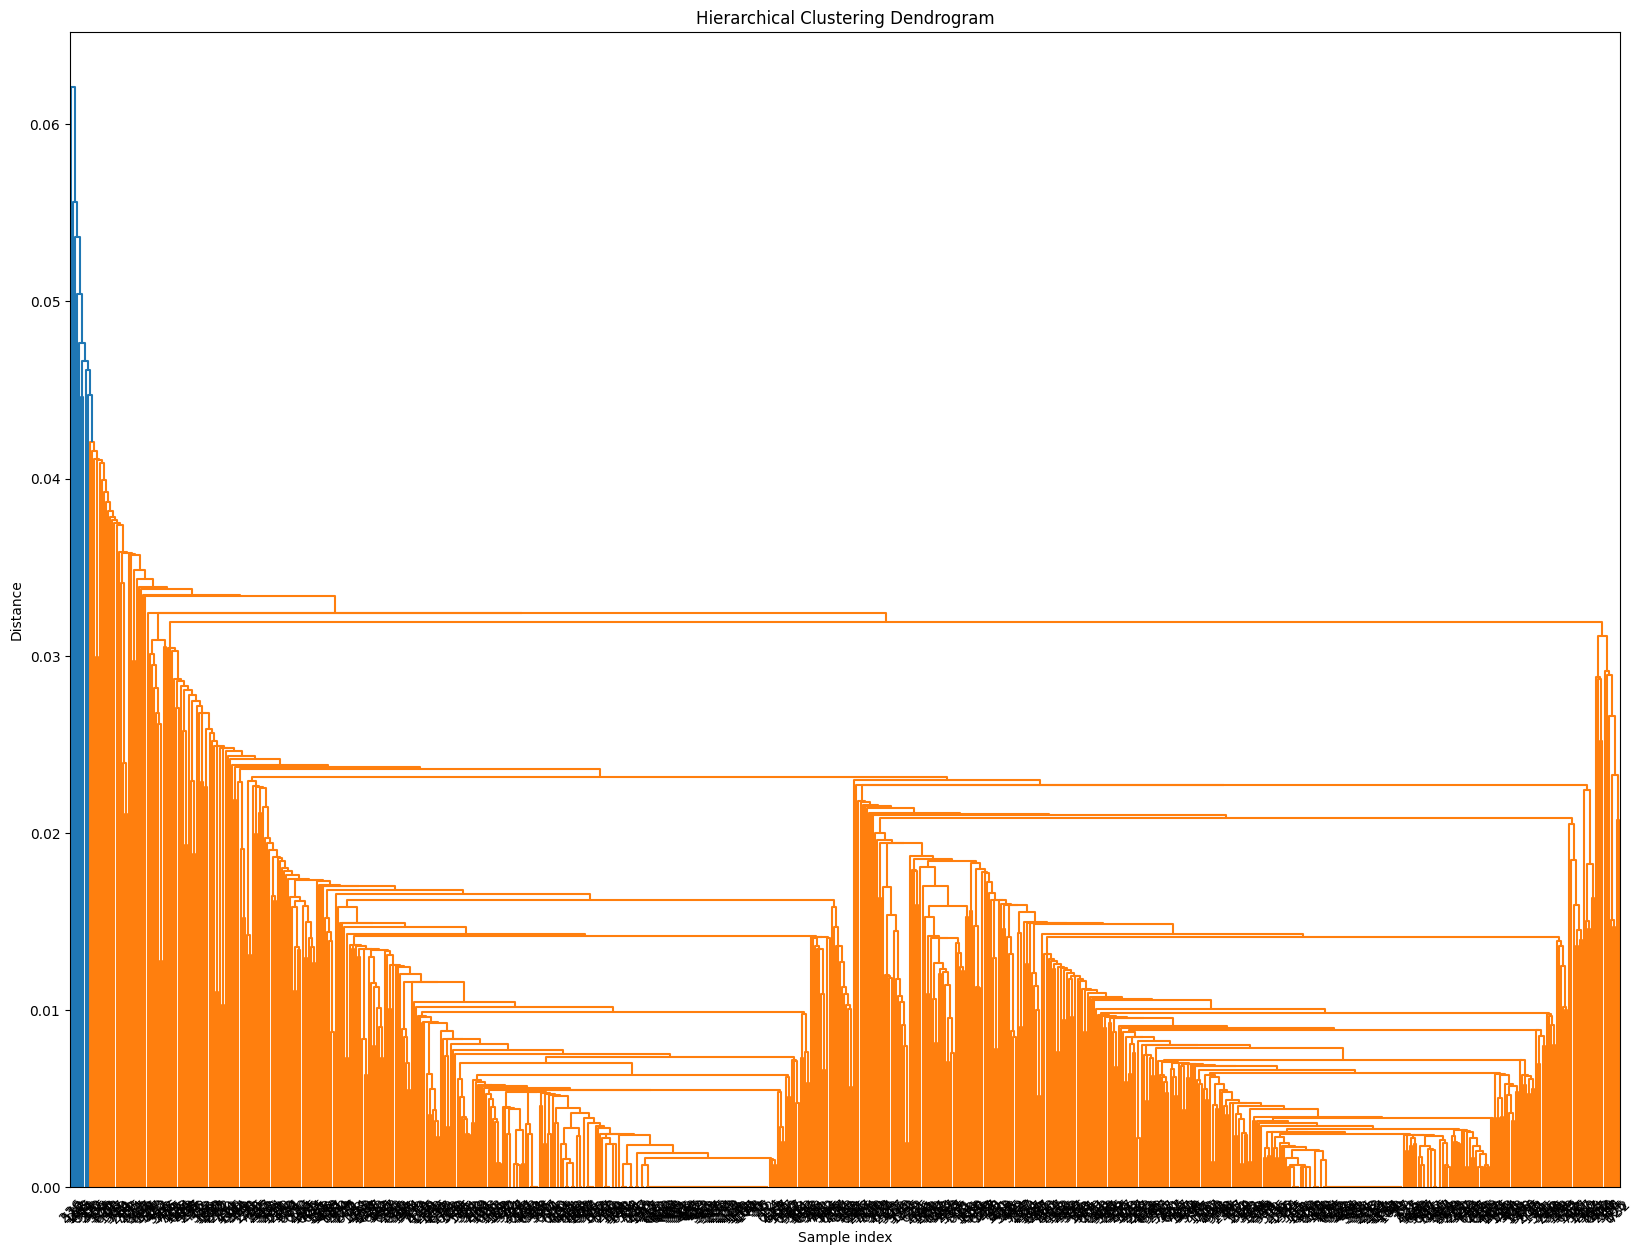

In [95]:
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree

Z = linkage(D, method = 'single')
plt.figure(figsize=(20, 15))
dendrogram(Z, truncate_mode=None, leaf_rotation=45, leaf_font_size=10.)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

In [ ]:

rootnode, nodelist = to_tree(Z, rd=True)

In [97]:
rootnode.id

1498

In [ ]:
class DDT(nn.Module):
    def __init__(self, input_dim, root, nodes, output_dim, use_cuda=False):
        super(DDT, self).__init__()
        self.root = root
        self.nodes = {node.id: node for node in nodes}
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.device = torch.device("cuda" if use_cuda else "cpu")

        self.internal_node_num_ = self.output_dim - 1
        self.leaf_node_num_ = self.output_dim        

        self.inner_nodes = nn.Sequential(
            nn.Linear(self.input_dim + 1, self.internal_node_num_, bias=False),
            nn.Sigmoid(),
            nn.Linear(self.internal_node_num_, self.output_dim, bias=False)
        )

        self.split_layers = nn.ModuleDict()
        for nid, node in self.nodes.items():
            if node.left is not None and node.right is not None:
                self.split_layers[str(nid)] = nn.Sequential(
                    nn.Linear(input_dim + 1, 1, bias = False),
                    nn.Sigmoid()
                )
    def forward(self, X):
        X = self._data_augment(X)
        batch_size = X.size(0)

        mu = {nid: torch.zeros(batch_size, 1, device=X.device)
              for nid in self.nodes}
        mu[self.root.id] = torch.ones(batch_size, 1, device = X.device)

        stack = [self.root.id]
        while stack:
            nid = stack.pop()
            node = self.nodes[nid]

            if node.left is None:
                continue
            
            p_left = self.split_layers[str(nid)](X)
            mu[node.left.id] += mu[nid] * p_left
            mu[node.right.id] += mu[nid] * (1 - p_left)

            stack.extend([node.left.id, node.right.id])

        leaf_probs = [mu[nid] for nid, node in self.nodes.items() if node.left is None]
        leaf_probs = torch.cat(leaf_probs, dim=1)
        leaf_probs = leaf_probs / (leaf_probs.sum(dim=1, keepdim=True) + 1e-8)

        return leaf_probs
    def _data_augment(self, X):
        """add bias feature as leading 1."""
        batch_size = X.size(0)
        X = X.view(batch_size, -1)
        bias = torch.ones(batch_size, 1, device=self.device)
        return torch.cat((bias, X), dim=1)
class TabularDataset(Dataset):
    def __init__(self, X, y):
        """
        X: DataFrame (features)
        y: numpy array (labels)
        """
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [101]:
input_dim = 10
output_dim = X_train.shape[0]
lr = 1e-3
batch_size = 128
epochs = 10
log_interval = 50
use_cuda = False
weight_decay = 5e-4


In [112]:
tree = DDT(input_dim, rootnode, nodelist, output_dim, use_cuda)
optimizer = torch.optim.Adam(tree.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

In [ ]:
train_dataset = TabularDataset(X_train, A)
test_dataset = TabularDataset(X_test, A_new)
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle=True
)

In [ ]:
best_testing_acc = 0.0
testing_acc_list = []
training_loss_list = []
criterion = nn.KLDivLoss(reduction='batchmean')
device = torch.device("cuda" if use_cuda else "cpu")

for epoch in range(epochs):
    tree.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.size()[0]
        data, target = data.to(device), target.to(device)
        output = tree.forward(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            msg = (
                "Epoch: {:02d} | Batch: {:03d} | Loss: {:.5f}"
            )
            print(msg.format(epoch, batch_idx, loss.item()))
            training_loss_list.append(loss.cpu().item())

    tree.eval()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        with torch.no_grad():
            output = tree.forward(data)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)

    avg_loss = total_loss / len(test_loader.dataset)
    print(f"\nEpoch {epoch:02d} | Testing Avg Loss: {avg_loss:.5f}\n")
    testing_acc_list.append(avg_loss)            

Epoch: 00 | Batch: 000 | Loss: -5.93151

Epoch 00 | Testing Avg Loss: -0.09784

Epoch: 01 | Batch: 000 | Loss: -5.91929

Epoch 01 | Testing Avg Loss: -0.09784

Epoch: 02 | Batch: 000 | Loss: -5.90071

Epoch 02 | Testing Avg Loss: -0.09784

Epoch: 03 | Batch: 000 | Loss: -5.90105

Epoch 03 | Testing Avg Loss: -0.09784

Epoch: 04 | Batch: 000 | Loss: -5.92241

Epoch 04 | Testing Avg Loss: -0.09784

Epoch: 05 | Batch: 000 | Loss: -5.89251

Epoch 05 | Testing Avg Loss: -0.09784

Epoch: 06 | Batch: 000 | Loss: -5.92664

Epoch 06 | Testing Avg Loss: -0.09784

Epoch: 07 | Batch: 000 | Loss: -5.90934

Epoch 07 | Testing Avg Loss: -0.09784

Epoch: 08 | Batch: 000 | Loss: -5.91885

Epoch 08 | Testing Avg Loss: -0.09784

Epoch: 09 | Batch: 000 | Loss: -5.90645

Epoch 09 | Testing Avg Loss: -0.09784

